# Clasificación binaria con algoritmo RandomForest e interpretación con LIME

*Este cuaderno está basado en parte en los contenidos del MOOC Machine Learning y Big Data para la Bioinformática y fue hecho para afianzar los conocimientos del mismo. Los datos utilizados provienen del siguiente artículo: 
Golub TR, Slonim DK, Tamayo P, Huard C, Gaasenbeek M, Mesirov JP, Coller H, Loh ML, Downing JR, Caligiuri MA, Bloomfield CD, Lander ES. Molecular classification of cancer: class discovery and class prediction by gene expression monitoring. Science. 1999 Oct 15;286(5439):531-7. doi: 10.1126/science.286.5439.531. PMID: 10521349.*

In [1]:
#Importamos las librerías que vamos a utilizar
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from graphviz import Source


from mlxtend.plotting import plot_decision_regions
import itertools
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

from imblearn.over_sampling import RandomOverSampler
import lime
import lime.lime_tabular

In [2]:
#Cargamos los datos de expresión y la variable clínica 
dataset = pd.read_csv('dataset.csv')
X, y = dataset.drop(columns=['Diagnostic', 'Patient']), dataset['Diagnostic'].replace({"ALL": 0, "AML": 1})

La variable clínica consiste en el diágnostico del paciente con leucemia linfoblástica aguda (ALL=0) o con leucemia mieloide aguda (AML = 1). En este notebook se pretenderá entrenar un clasificador que permita, a partir de los valores de expresión génica, predecir si tiene una u otra enfermedad. 

A continuación, describimos los principales parámetros estadísticos de pacientes con ALL o AML. 

In [3]:
print("Parámetros estadísticos ALL: ")
X[y==0].describe()

Parámetros estadísticos ALL: 


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,-122.468085,-170.553191,-17.191489,167.765957,-253.000000,-402.297872,-52.93617,-182.744681,75.382979,58.595745,...,166.787234,672.744681,-11.595745,369.510638,-33.12766,729.723404,304.297872,11.787234,318.170213,-38.829787
std,106.306540,103.665811,140.119613,113.852157,125.339365,164.107854,306.75223,100.924524,83.185898,202.370695,...,99.820695,309.385398,93.547398,437.394851,53.90798,417.500102,228.912449,50.331914,423.169270,39.965920
min,-476.000000,-531.000000,-410.000000,-36.000000,-541.000000,-810.000000,-1038.00000,-463.000000,-148.000000,-468.000000,...,-58.000000,91.000000,-295.000000,-24.000000,-220.00000,67.000000,-42.000000,-207.000000,-33.000000,-190.000000
25%,-153.500000,-218.500000,-99.500000,79.500000,-312.500000,-517.000000,-203.00000,-209.500000,8.000000,-68.000000,...,89.500000,468.500000,-66.500000,175.000000,-58.50000,453.500000,167.000000,-0.500000,106.000000,-62.000000
50%,-106.000000,-153.000000,-21.000000,168.000000,-230.000000,-394.000000,-66.00000,-153.000000,70.000000,31.000000,...,158.000000,639.000000,6.000000,249.000000,-22.00000,646.000000,302.000000,14.000000,193.000000,-39.000000
75%,-62.000000,-95.500000,42.500000,256.000000,-176.000000,-279.500000,115.50000,-120.500000,131.000000,188.000000,...,229.000000,836.000000,45.500000,452.500000,1.50000,865.500000,388.000000,33.500000,308.500000,-17.000000
max,86.000000,-13.000000,312.000000,431.000000,114.000000,-122.000000,709.00000,-24.000000,252.000000,506.000000,...,413.000000,1455.000000,218.000000,2527.000000,52.00000,1950.000000,1109.000000,115.000000,1971.000000,36.000000


In [4]:
print("Parámetros estadísticos AML: ")
X[y==1].describe()

Parámetros estadísticos AML: 


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,-99.760000,-140.520000,9.080000,229.92000,-253.880000,-384.520000,-87.040000,-205.640000,88.920000,172.640000,...,191.44000,660.160000,-12.040000,404.920000,-34.680000,876.120000,303.280000,5.400000,650.280000,-15.040000
std,79.052346,78.298638,80.230356,97.78161,118.546165,122.425188,242.161186,98.169021,101.298207,255.879998,...,81.87291,304.854293,76.332322,237.308154,49.434907,503.720766,160.357029,32.773211,856.377133,36.506255
min,-318.000000,-370.000000,-125.000000,31.00000,-456.000000,-581.000000,-726.000000,-390.000000,-86.000000,-217.000000,...,36.00000,244.000000,-275.000000,139.000000,-112.000000,87.000000,51.000000,-68.000000,-68.000000,-71.000000
25%,-137.000000,-185.000000,-50.000000,170.00000,-369.000000,-478.000000,-221.000000,-271.000000,-1.000000,-7.000000,...,134.00000,470.000000,-45.000000,261.000000,-66.000000,524.000000,208.000000,-12.000000,196.000000,-33.000000
50%,-95.000000,-122.000000,12.000000,230.00000,-209.000000,-385.000000,-34.000000,-210.000000,100.000000,167.000000,...,195.00000,621.000000,-8.000000,334.000000,-45.000000,752.000000,279.000000,0.000000,298.000000,-10.000000
75%,-32.000000,-100.000000,49.000000,318.00000,-171.000000,-287.000000,29.000000,-123.000000,153.000000,320.000000,...,214.00000,755.000000,35.000000,462.000000,11.000000,1110.000000,361.000000,26.000000,662.000000,0.000000
max,15.000000,-20.000000,212.000000,392.00000,-51.000000,-155.000000,358.000000,-11.000000,283.000000,878.000000,...,409.00000,1653.000000,102.000000,1075.000000,42.000000,2315.000000,642.000000,73.000000,3193.000000,78.000000


Realizamos un análisis de componentes principales (para reducir la dimensionalidad de las instancias) y realizamos una representación gráfica. 

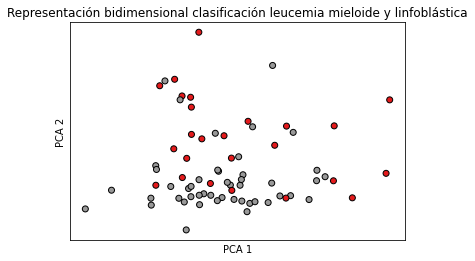

In [5]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)
st = StandardScaler()
X_2D = st.fit_transform(X_2D)

plt.scatter(X_2D[:, 0], X_2D[:, 1], cmap=plt.cm.Set1, c=pd.get_dummies(y).iloc[:,0], edgecolor='k')
plt.title("Representación bidimensional clasificación leucemia mieloide y linfoblástica")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xticks(())
plt.yticks(())
plt.show()

## Sets entrenamiento y test

Separamos instancias de entrenamiento y de test mediante validación tipo hold-out.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print("Numero de instancias en entrenamiento: {0} y test: {1}".format(len(X_train),len(X_test)))

Numero de instancias en entrenamiento: 54 y test: 18


In [7]:
print('Número de casos con ALL: {0}. Número de casos con AML: {1}'.format(sum(y==0), sum(y==1)))

Número de casos con ALL: 47. Número de casos con AML: 25


Puesto que nuestro dataset se encuentra muy desbalanceado, utilizamos una estrategia de sobremuestreo para balancearlo a una proporción 1:1. Usamos para ello la librería **imblearn**. Para solventar que los casos de AML estén infrarrepresentados usamos una estrategia de sobremuestreo (generar nuevas instancias muestreando con reemplazo las instancias preexistentes).

In [8]:
sampling_strategy = 1 #proporción 1:1
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train, y_train = ros.fit_resample(X_train, y_train)
#X_test, y_test = ros.fit_resample(X_test, y_test) Aplicar sobremuestreo a set de prueba

In [9]:
print('Número de casos subgrupo entrenamiento con ALL: {0}. Número de casos con AML: {1}'.format(sum(y_train==0), sum(y_train==1)))
print('Número de casos subgrupo test con ALL: {0}. Número de casos con AML: {1}'.format(sum(y_test==0), sum(y_test==1)))

Número de casos subgrupo entrenamiento con ALL: 35. Número de casos con AML: 35
Número de casos subgrupo test con ALL: 12. Número de casos con AML: 6


## Clasificación mediante RandomForest

Empleamos algoritmo RandomForest de *sklearn*:

In [10]:
rf = RandomForestClassifier(n_estimators=500, random_state=43)
rf.fit(X_train, y_train) 

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido por RF es",acc*100)

El porcentaje de acierto obtenido por RF es 77.77777777777779


Calculamos los principales parámetros estadísticos del clasificador:

In [11]:
print(classification_report(y_test,y_pred))
f1 = f1_score(y_test,y_pred)
print("La medida F1 para el clasificador %s es %.4f"%(rf.__class__.__name__,f1))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.33      0.50         6

    accuracy                           0.78        18
   macro avg       0.88      0.67      0.68        18
weighted avg       0.83      0.78      0.74        18

La medida F1 para el clasificador RandomForestClassifier es 0.5000


## Interpretación clasificador

Una de las dificultades a la hora de utilizar algoritmos de caja negra es su interpretabilidad. ¿Por qué tiene una baja sensibilidad a los pacientes con AML? ¿Qué es lo que sobreexpresan o infraexpresan los pacientes con ALL y que el clasificador es capaz de reconocer?

Para buscar las variables de entrada que más contribuyen a predecir la salida:

#### Reducción nº de variables

Representamos las 25 variables más determinantes en la predicción del modelo:

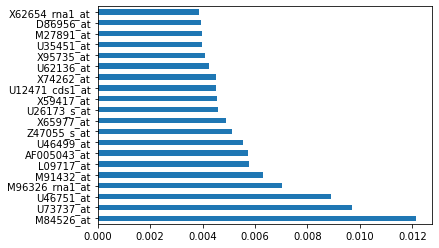

In [12]:
importancia = rf.feature_importances_
(pd.Series(importancia, index=X_train.columns).nlargest(20).plot(kind='barh'))
plt.show()

Si a continuación volvemos a entrenar el modelo con únicamente las n- variables más importantes, ¿empeora significativamente la calidad del clasificador? Realizando pruebas, se determina que la relación nº de variables/ calidad del modelo es óptima con 10 las variables que más contribuyen a la predicción. 

In [28]:
fs = SelectFromModel(rf,prefit=True, max_features=10) 
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

rf_fs = RandomForestClassifier(random_state=43)      #Reentrenamos modelo específico de menos variables
rf_fs.fit(X_train_fs, y_train)

y_pred = rf_fs.predict(X_test_fs)
acc = accuracy_score(y_test,y_pred)
print("El acierto con el modelo simplificado a %d variables es %.4f"%(X_test_fs.shape[1],acc*100))


El acierto con el modelo simplificado a 10 variables es 77.7778


Puesto que las predicciones dependen mucho de la forma en que se han dividido los datos, procedemos a realizar validación cruzada:

In [32]:
from sklearn.model_selection import cross_val_score
rf_fs_cross = RandomForestClassifier(random_state=43)
scores = cross_val_score(rf_fs_cross, fs.transform(X), y, cv=5)
print("%0.2f de acierto con una desviación estándar de  %0.2f" % (scores.mean(), scores.std()))

0.79 de acierto con una desviación estándar de  0.16


In [31]:
scores = cross_val_score(
rf_fs_cross, fs.transform(X), y, cv=5, scoring='f1_macro')
scores
print("%0.2f de F1 con una desviación estándar de  %0.2f" % (scores.mean(), scores.std()))

0.74 de F1 con una desviación estándar de  0.18


#### Visualización RandomForest reducido

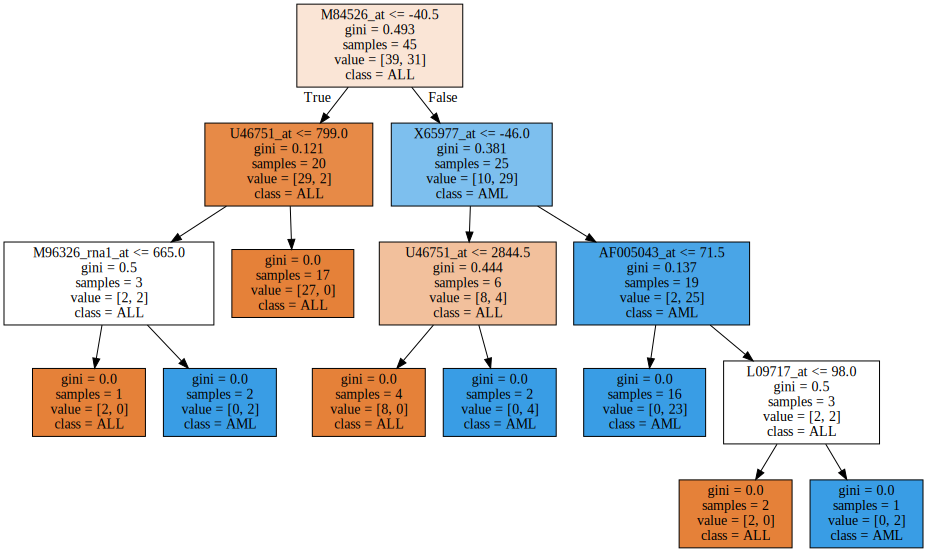

In [34]:
dt = rf_fs.estimators_[0]
feature_idx = fs.get_support()
feature_name = X.columns[feature_idx]
tree_graph = tree.export_graphviz(dt, out_file=None, 
                                  feature_names=feature_name, 
                                  class_names=['ALL', 'AML'],
                                  filled = True)
graph = Source(tree_graph)
graph


#### Interpretación LIME

Por último, recurriremos a la librería **LIME** para abordar la interpretación de un modelo de caja negra como este (aunque bastante simplificado, teniendo en cuenta cómo se ha reducido el nº de variables de entrada).

LIME permita encontrar la explicación al comportamiento del modelo para la predicción de una instancia determinada, aproximando su comportamiento como lineal en ese punto. 

In [35]:
X_train_red=X_train[feature_name]
X_test_red=X_test[feature_name]

explainer =lime.lime_tabular.LimeTabularExplainer(X_train_red.to_numpy(), 
                                                  feature_names=list(feature_name),
                                                  verbose=True, 
                                                  mode='classification',  
                                                  discretize_continuous=True, #a cuartiles
                                                  class_names=['ALL', 'AML'])


Mediante un análisis detallado de las explicaciones que da LINE para cada una de las predicciones, se podrían determinar las fortelezas/debilidades del modelo y obtener información de gran interés en si misma. A continaución, mostramos algunos ejemplos.

- Los resultados que arroja LIME para un paciente con AML diagnosticado **correctamente** son: 

Intercept 0.46125202178777636
Prediction_local [0.57431738]
Right: 0.71


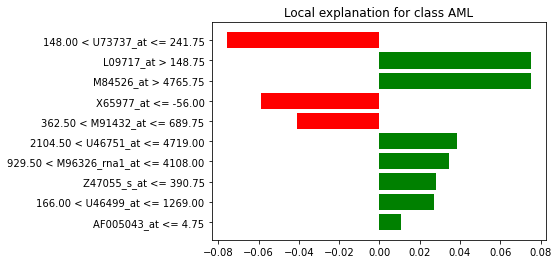

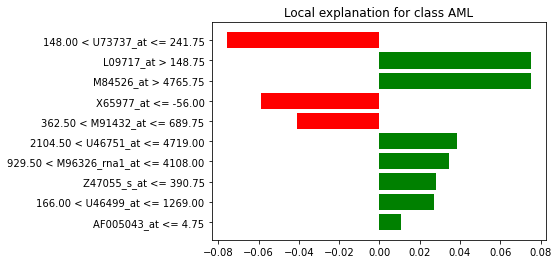

In [45]:
exp = explainer.explain_instance(X_test_red.iloc[6].to_numpy(), 
     rf_fs.predict_proba,num_samples=500)
exp.as_pyplot_figure()

- Los resultados que arroja LIME para un paciente con AML diagnosticado **erróneamente** son: 

Intercept 0.6028764571818164
Prediction_local [0.16979177]
Right: 0.07


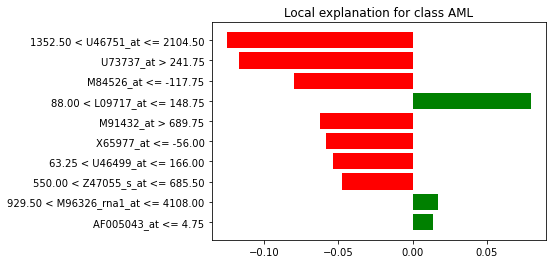

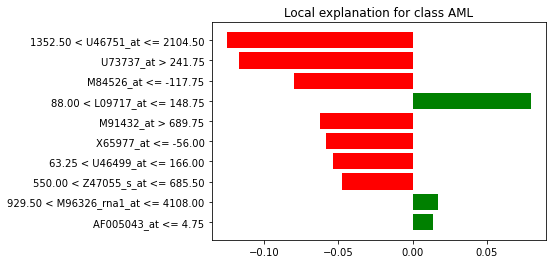

In [48]:
exp = explainer.explain_instance(X_test_red.iloc[3].to_numpy(), 
     rf_fs.predict_proba,num_samples=500)
exp.as_pyplot_figure()

- Los resultados que arroja LIME para un paciente con ALL diagnosticado **correctamente** son: 